In [1]:
import numpy as np
import matplotlib.pyplot as plt
import finesse
import finesse.virgo
import finesse.analysis.actions as fac
finesse.init_plotting()

## Intro
The purpose of this notebook is to demonstrate the process of tuning a full interferometer model to achieve a desired operating point, even in the presence of defects. 

The first part of the notebook focuses on using the features provided by the `finesse-virgo` package to tune the system in two different way: by using optimizers and running the locks to zero the error signals. In the second part, we will learn **(together)** how to do the same when defects are involved.

Below, we prepare the Virgo model to be used by: loading the model and adjusting the length of the recycling cavities.

#### Recycling cavity lengths

The recycling cavities (PRC, SRC) are designed with specific matching conditions between their lengths and the RF modulation frequencies. To achieve this, we adjust the lengths of the PRC and SRC by changing the distances between the mirrors. While the modulation frequency is often known precisely from the experiment and can be readout from the signal generator, determining the distances between the mirrors with the same level of precision can be more challenging.

In [2]:
virgo = finesse.virgo.Virgo() # creating a virgo model using the custom Virgo kat file

# step 1: adjust the macroscopic cavity lengths
virgo.adjust_PRC_length()
virgo.adjust_SRC_length()

## Main Task: Finding an operating point
#### Method 1 - Pretuning

In the pretuning process, we optimize the configuration of the model to achieve desired resonance conditions. This involves utilizing the power of the carrier (the main laser beam without RF modulation). 

The following steps outline the pretuning method:

- Switch off the modulators -> only use main carrier field in the following steps
- remove the SR and PR mirrors -> this removed any cross-coupling between the two arms, so we can tune them independently from each other
- Move the arm cavity end mirrors to `maximise` power in each arm -> arm cavities are on resonance
- Move the arm cavities to `minimise` power at the output -> interferometer is at the dark fringe
- Restore the PR mirror, and move it to `maximise` power in the PRC -> PRC is on resonance
- Restore the SR mirror, and move it to `maximise` power in the SRC -> SRC is on resonance
- Offset SR by 90° to place the interferometer on a dark fringe -> SRC is in the condition for Resonant Sideband Extraction (RSE)
- Restore the modulators -> for future tasks we require the RF modulation sidebands 

The pretuning method uses `optimizers`. For an example of how to use optimizers to bring a system to the operating point have a look at: [here](https://git.ligo.org/IFOsim/ifosimworkshop2023/-/blob/main/Finesse3_tutorial/03_finesse3_workshop_defects.ipynb)

In [3]:
virgo.model.run(
    fac.TemporaryParameters(
        fac.Series(
            fac.Change({"eom6.midx": 0, "eom8.midx": 0, "eom56.midx": 0, "SR.misaligned": True, "PR.misaligned": True,  "SRAR.misaligned": True, "PRAR.misaligned": True}),
            # Maximise arm power
            fac.Maximize("B7_DC", "NE_z.DC", bounds=[-180,180], tol=1e-14),
            fac.Maximize("B8_DC", "WE_z.DC", bounds=[-180,180], tol=1e-14),
            # Minimise dark fringe power
            fac.Minimize("B1_DC", "MICH.DC", bounds=[-180,180], tol=1e-14),
            # Bring in PR
            fac.Change({"PR.misaligned": False}),
            # Maximise PRC power
            fac.Maximize("CAR_AMP_BS", "PRCL.DC", bounds=[-180,180], tol=1e-14),
            # Bring in SR
            fac.Change({"SR.misaligned": False}),
            # Maximise SRC power, then offset by 90°
            fac.Change({"SRCL.DC": 0}),
            fac.Maximize("B1_DC", "SRCL.DC", bounds=[-180,180], tol=1e-14),
            fac.Change({"SRCL.DC": -90}, relative=True)),
        exclude=("PR.phi", "NI.phi", "NE.phi", "WI.phi", "WE.phi", "SR.phi", "NE_z.DC", "WE_z.DC", "MICH.DC", "PRCL.DC", "SRCL.DC")
    )
)

<BaseSolution of series/series @ 0x11e8699e0 children=5>

The same can be done in a more concise way by using the `finesse-virgo` in-built `pretune` method.

In [4]:
# step 1: pretuning
virgo.model.i1.P=25

virgo.pretune()

**Task**:  check each DOF against the power at the relevant detector, to check that they're all at maxima / minima.

In [5]:
virgo.plot_powers()
plt.show()

## Method 2: Running the lock
The pre-tuning using the carrier power alone is a good start but typically not sufficient to set the interferometer operating point. To achieve the desired configuration, we rely on the length-sensing and control (LSC) signals employed in the experiment for mirror position control. This approach ensures that we accurately account for the effects induced by the control loops, including scenarios where a mispositioning of a mirror occurs due to an optical defect. By incorporating the LSC signals, we address these additional factors and refine the tuning process accordingly.
#### Length sensing and control signal 
It is worth noting that we frequently utilize the control signals even in cases where modeling the effects of the LSC system is not necessary. Based on our experience, employing the readouts from the experiment proves to be effective in automatically adjusting the operating point in the simulation. This approach has demonstrated good results, allowing us to leverage real-world data to fine-tune the operating parameters without the need for explicitly modeling the LSC system's effects.

We will do the following steps:
 - add the readouts that are being used to generating the error signals for the LSC system
 - define which readout is used for which degree of freedom (DOF)
 - optimise the demodulation phases for each RF readout
 - compute the DC optical gains for each control transfer function 
 - use the information from the previous steps to add `lock` commands
 - run the model once with the `lock` commands which brings the interferometer more accurately

For a reference of how to lock a cavity with a PDH and optimize the control strategy have a look at: [here](https://git.ligo.org/IFOsim/ifosimworkshop2023/-/blob/main/Finesse3_tutorial/02_finesse3_workshop_locked_cavity.ipynb) and [here](https://git.ligo.org/IFOsim/ifosimworkshop2023/-/blob/main/Finesse3_tutorial/03_finesse3_workshop_defects.ipynb)
The structure is the same as that used below.

In [6]:
# step 3: optimize demodulation phases
virgo.optimize_demodulation_phase()

# step 4: optimize lock gains
virgo.optimize_lock_gains()

# step 5: run RF locks
virgo.model.run(fac.RunLocks(method="newton"))

<RunLocksSolution of series/run locks @ 0x11e466aa0 children=0>

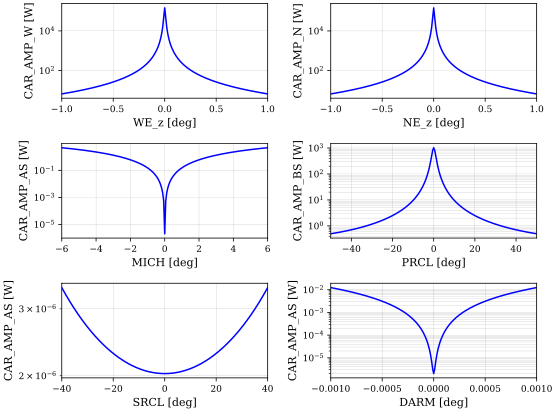

In [7]:
virgo.plot_powers()
plt.show()

In [8]:
print(virgo.control_scheme)

{'PRCL': ('B2_8', 'I', None, 1e-12), 'MICH': ('B2_56', 'Q', None, 1e-11), 'CARM': ('B2_6', 'I', None, 1e-14), 'DARM': ('B1p_56', 'I', None, 1e-14), 'SRCL': ('B2_56', 'I', None, 5e-10)}


In [9]:
print(virgo.model.PRCL_lock.error_signal)

ReadoutDetectorOutput('B2_8_I')


In [9]:
print(virgo.model.DARM_rf_lock.error_signal)
print(virgo.model.DARM_rf_lock.gain)
print(virgo.model.DARM_dc_lock.error_signal)
print(virgo.model.DARM_dc_lock.gain)

ReadoutDetectorOutput('B1p_56_I')
-0.010508688130812042
ReadoutDetectorOutput('B1_DC')
-0.010508688130812042


In [10]:
virgo.print_locks()

 ╔═══════════════════════════════════════════════════════╗
 ║ Parameters for locks:                                 ║
 ╠═══════════════════════════════════════════════════════╣
 ║ Lock name      port     DOF      lock gain   disabled ║
 ║ PRCL_lock      B2_8_I   PRCL.DC     -1e+02      False ║
 ║ MICH_lock      B2_56_Q  MICH.DC    3.2e+03      False ║
 ║ CARM_lock      B2_6_I   CARM.DC      -0.26      False ║
 ║ DARM_rf_lock   B1p_56_I DARM.DC     -0.011      False ║
 ║ DARM_dc_lock   B1_DC    DARM.DC     -0.011       True ║
 ║ SRCL_lock      B2_56_I  SRCL.DC   -6.1e+03      False ║
 ╟───────────────────────────────────────────────────────╢
 ║ Accuracies        [deg]            [m]            [W] ║
 ║ PRCL     :  0.000338346          1e-12        5.3e-06 ║
 ║ MICH     :   0.00338346          1e-11        9.1e-07 ║
 ║ CARM     :  3.38346e-06          1e-14        1.6e-05 ║
 ║ DARM     :  3.38346e-06          1e-14         0.0017 ║
 ║ SRCL     :     0.169173          5e-10        2.2e-05

In [11]:
import finesse.virgo.actions as facV

In [25]:
facV.DARM_RF_to_DC??


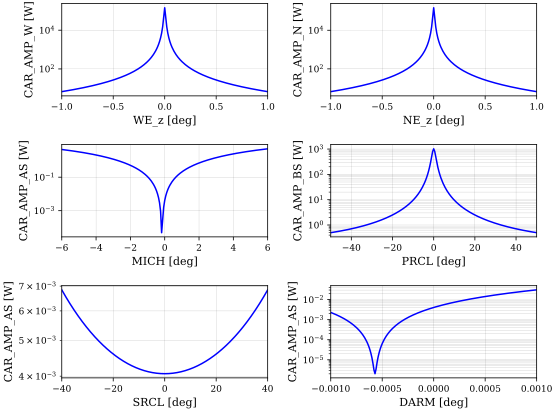

In [12]:
virgo_DC_1 = virgo.deepcopy()
virgo_DC_1.model.run(facV.DARM_RF_to_DC(dc_offset=0.001))
virgo_DC_1.model.run(fac.RunLocks(method="newton"))
virgo_DC_1.plot_powers()
plt.show()

0.0017

In [33]:
#virgo.plot_powers()
#lt.show()


In [20]:
virgo_DC_2 = virgo.deepcopy()
virgo_DC_2.model.DARM_dc_lock.disabled=False
virgo_DC_2.model.DARM_rf_lock.disabled=True
virgo_DC_2.model.DARM_dc_lock.offset=0.001
virgo_DC_2.model.DARM.DC += -1e-3
virgo_DC_2.optimize_lock_gains()
virgo_DC_2.model.DARM_dc_lock.accuracy = 1e-6
virgo_DC_2.model.run(fac.RunLocks(method="newton"))
virgo_DC_2.plot_powers()
plt.show()

In [21]:
#find the correct dc offset
virgo_DC_1.print_locks()
virgo_DC_2.print_locks()

 ╔═══════════════════════════════════════════════════════╗
 ║ Parameters for locks:                                 ║
 ╠═══════════════════════════════════════════════════════╣
 ║ Lock name      port     DOF      lock gain   disabled ║
 ║ PRCL_lock      B2_8_I   PRCL.DC     -1e+02      False ║
 ║ MICH_lock      B2_56_Q  MICH.DC    3.2e+03      False ║
 ║ CARM_lock      B2_6_I   CARM.DC      -0.26      False ║
 ║ DARM_rf_lock   B1p_56_I DARM.DC     -0.011       True ║
 ║ DARM_dc_lock   B1_DC    DARM.DC      -0.01      False ║
 ║ SRCL_lock      B2_56_I  SRCL.DC   -6.1e+03      False ║
 ╟───────────────────────────────────────────────────────╢
 ║ Accuracies        [deg]            [m]            [W] ║
 ║ PRCL     :  0.000338346          1e-12        5.3e-06 ║
 ║ MICH     :   0.00338346          1e-11        9.1e-07 ║
 ║ CARM     :  3.38346e-06          1e-14        1.6e-05 ║
 ║ DARM     :  3.38346e-06          1e-14         0.0017 ║
 ║ SRCL     :     0.169173          5e-10        2.2e-05

In [22]:
virgo_DC_2.print_powers()
virgo_DC_1.print_powers()

┌──────────────╥───────────┬────────────┐
│   Detector   ║ Power [W] │ Pow. ratio │
╞══════════════╬═══════════╪════════════╡
│ CAR_AMP_PRin ║        25 │          1 │
│  CAR_AMP_N   ║ 1.552e+05 │       6210 │
│  CAR_AMP_W   ║ 1.541e+05 │       6165 │
│  CAR_AMP_BS  ║      1095 │      43.82 │
│  CAR_AMP_AS  ║  0.001033 │  4.133e-05 │
└──────────────╨───────────┴────────────┘

┌──────────────╥───────────┬────────────┐
│   Detector   ║ Power [W] │ Pow. ratio │
╞══════════════╬═══════════╪════════════╡
│ CAR_AMP_PRin ║        25 │          1 │
│  CAR_AMP_N   ║ 1.552e+05 │       6209 │
│  CAR_AMP_W   ║ 1.541e+05 │       6164 │
│  CAR_AMP_BS  ║      1095 │      43.81 │
│  CAR_AMP_AS  ║  0.004343 │  0.0001737 │
└──────────────╨───────────┴────────────┘



/Users/camilla/mambaforge/envs/finesse3/lib/python3.10/site-packages/finesse/analysis/actions/base.py:133: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


(<Figure size 480x336 with 1 Axes>,
 array([[<Axes: title={'center': 'lf.AC'}, xlabel='Frequency [Hz]', ylabel='OUTPUT/DOF'>]],
       dtype=object))

<Figure size 576x355.968 with 0 Axes>

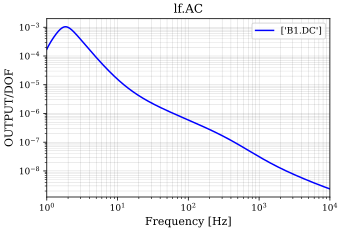

In [16]:
###frequency noise
virgo_freq = virgo_DC_1.deepcopy()
#model1=virgo.model.deepcopy() #disable radiation pressure
#model1.NI_sus.mass = np.inf
#model1.NE_sus.mass = np.inf
#model1.WI_sus.mass = np.inf
#model1.WE_sus.mass = np.inf

virgo_freq.model.parse("""
dof lf i1.dofs.frq +1
""")

sol1 = virgo_freq.model.run(
    fac.FrequencyResponse(
        f = np.geomspace(1, 10000, 1000),
        inputs=('lf.AC'),
        outputs=('B1.DC')
    )
)
sol1.plot()

array([<Axes: title={'center': 'DARM TF'}, ylabel='Amplitude [$\\sqrt{W}$]'>,
       <Axes: xlabel='f [Hz]', ylabel='Phase [deg]'>], dtype=object)

<Figure size 576x355.968 with 0 Axes>

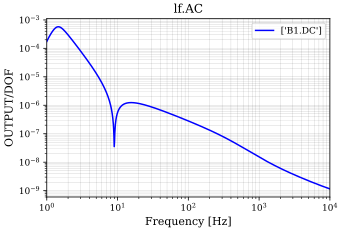

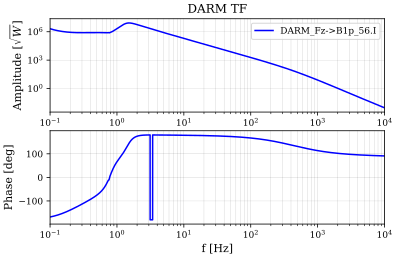

In [31]:
###frequency noise
virgo_freq = virgo_DC_2.deepcopy()
model1=virgo_freq.model#disable radiation pressure
#model1.NI_sus.mass = np.inf
#model1.NE_sus.mass = np.inf
##model1.WI_sus.mass = np.inf
#model1.WE_sus.mass = np.inf
#model1.BS_sus.mass = np.inf


virgo_freq.model.parse("""
dof lf i1.dofs.frq +1
""")

sol1 = virgo_freq.model.run(
    fac.FrequencyResponse(
        f = np.geomspace(1, 10000, 1000),
        inputs=('lf.AC'),
        outputs=('B1.DC')
    )
)
sol1.plot()
virgo_freq.plot_DARM(axis=[0.1,10000,10000])

In [17]:
virgo_freq = virgo_DC_1.deepcopy()
#model1=virgo.model.deepcopy() #disable radiation pressure
virgo_freq.model.NI_sus.mass = np.inf
virgo_freq.model.NE_sus.mass = np.inf
virgo_freq.model.WI_sus.mass = np.inf
virgo_freq.model.WE_sus.mass = np.inf
virgo_freq.model.BS_sus.mass = np.inf


virgo_freq.model.parse("""
dof lf i1.dofs.frq +1
""")

sol1 = virgo_freq.model.run(
    fac.FrequencyResponse(
        f = np.geomspace(0.001, 10000, 1000),
        inputs=('DARM'),
        outputs=('B1.DC')
    )
)
sol1.plot()
virgo_freq.plot_DARM()

array([<Axes: title={'center': 'DARM TF'}, ylabel='Amplitude [$\\sqrt{W}$]'>,
       <Axes: xlabel='f [Hz]', ylabel='Phase [deg]'>], dtype=object)

<Figure size 576x355.968 with 0 Axes>

In [ ]:
model1.CARM.DC

In [ ]:
###frequency noise
model1=virgo.model.deepcopy()
model1.NI_sus.mass = np.inf
model1.NE_sus.mass = np.inf
model1.WI_sus.mass = np.inf
model1.WE_sus.mass = np.inf
model1.DARM.DC = 0.001
sol1 = model1.run(
    fac.FrequencyResponse(
        f = np.geomspace(10, 10000, 1000),
        inputs=('DARM.AC'),
        outputs=('B1.DC')
    )
)
sol1.plot()

In [ ]:
###frequency noise
model1=virgo.model.deepcopy()
model1.parse("""
dof lf i1.dofs.frq +1

""")
model1.DARM.DC = 0.001
model1.CARM.DC = 0.00
model1.NI.R = 1- model1.NI.T.ref - model1.NI.L.ref

model1.BSAR1.R = 1- model1.BSAR1.T.ref - model1.BSAR1.L.ref
model1.BSAR1.T = 1
model1.BSAR1.L = 0

sol1 = model1.run(
    fac.FrequencyResponse(
        f = np.geomspace(10, 10000, 1000),
        inputs=('lf.AC'),
        outputs=('B1.DC')
    )
)
sol1.plot()

In [ ]:
model1.BSAR1.L = 

This **example** should be  customized for specific tasks. The recipe used below works out-of-the-box for some initial conditions but it cannot find an operating point for arbitrary starting conditions. For example, if a large defect is included in the model, like a strong mode-mismatch, the automatic functions below will likely fail and not find the correct operating point.

## Task: Agree on a Task and customize the tuning strategy accordingly